In [1]:
import matplotlib.pyplot as plt
import numpy as np

My initial attempt to keep track of phase note-to-note are not so great. The code for this is directly below. This "works" but has problems when the sines are of different amplitude. 

However, I had some issues, so I will try some approaches from this DSP Stack Exchange I asked.
https://dsp.stackexchange.com/questions/83009

phase_offset=26.38937829015426


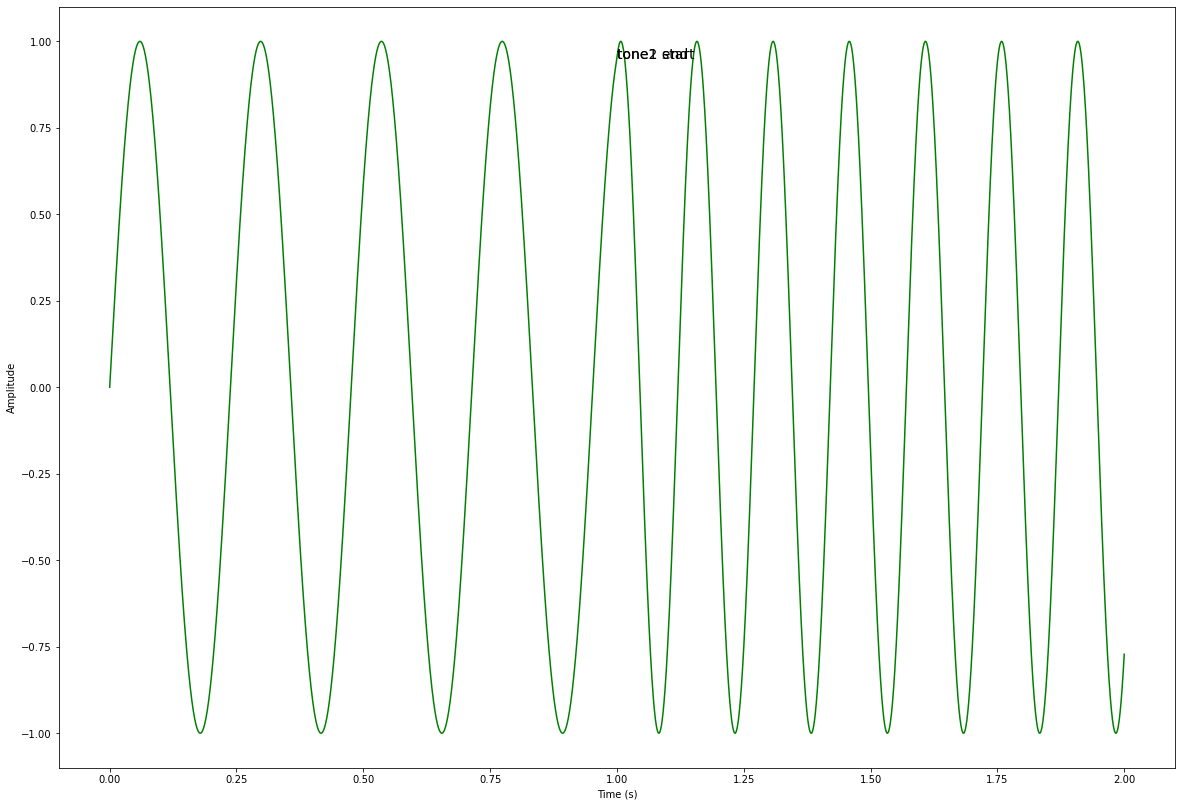

In [5]:
sr = 22050
ts = 1.0/sr
duration = 1
t = np.arange(0,duration,ts)

freq = 4.20
sine1 = 1*np.sin(2*np.pi*freq*t+0)

phase_increment = 2*np.pi*freq/sr
phase_offset = phase_increment * len(sine1)
print(f'{phase_offset=}')

freq = 6.66
sine2 = 1*np.sin(2*np.pi*freq*t+phase_offset)

plot_tone = np.concatenate([sine1, sine2])
plot_t = np.arange(0,duration*2,ts)

plt.figure(figsize = (20, 14))
plt.plot(plot_t, plot_tone, 'green')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.annotate('tone1 end', (1, sine1[-1]), fontsize=14)
plt.annotate('tone2 start', (1, sine2[0]), fontsize=14)
plt.savefig('concat_sine_with_offset_amp_difference.png')
plt.show()

## Implementation, as described here: 
https://dsp.stackexchange.com/a/83058/62456

> ### Use phase from the start, and do not just multiply by time t - this is vital 
For each sine wave, use a variable to hold the current phase. 
Then for each time step, multiply 2 * np.pi * freq by the time step interval and add that incremental change to the previous phase value. 
You'll also need to check for the sum exceeding 2*np.pi and subtract 2*np.pi when it does. With this solution, you're guaranteed a stepless frequency change.
>
> There's an even more important benefit from this too, which is essential to know for real-world DSP. 
As time t becomes larger, the value will start to run out of floating-point precision for the time step interval. 
Your sine wave will become progressively less accurate as the program runs, until at some point the value loses precision entirely and the sine wave will simply stop moving. 
The lower the frequency and the shorter the sample rate, the sooner this'll happen; but maths says it will always happen eventually. 
This is a very common bug for novice DSP implementations, and it's often not obvious because everything may seem to work fine until you've had your code running for a few hours and then it mysteriously just freezes.
>
> Incremental phase changes do have a similar issue of course, where the increment may be too small to represent with your floating-point precision. 
Using double-precision floating-point is usually the way to go here. 
The advantage you have with this though is that if there is a precision problem, you're guaranteed to see it within one sine-wave period, so it won't come as some kind of surprise.
>
> ### Ramp amplitudes if they can change
>
> Your code has a fixed amplitude of 1 for both sine waves. (By the way, if the amplitude is 1 then you don't need to multiply by it.) If you want changes to amplitude to be stepless, one solution is to ramp the amplitude from the previous value to the new value. You can choose a suitable ramp period for your application.
> 
> ### And/or change settings at zero crossing
> The other simple strategy for amplitude changes is to hold off changing until the next zero-crossing of the sine wave. Multiplying anything by zero results in zero, so you're guaranteed that this will be stepless. This works well for fast sine waves. For slow sine waves where the sine wave period may be longer than a reasonable ramp transition, it might not be the best strategy though.
>
>Changing settings at the zero crossing can also work for frequencies too, but there's generally less reason to need that. Still though, if you want the frequency and magnitude to both change in step with each other, you can change them both when the phase crosses 2*np.pi, and you're good. By the way, don't expect the phase to ever exactly hit 2*np.pi, so a zero-crossing transition is never going to be perfectly stepless, but it's still likely to be better than most other strategies.

In [150]:
sr = 220
ts = 1.0/sr

freq1 = 4.20
dur1 = 0.5
amp1 = 1.0

freq2 = 6.66
dur2 = 0.5
amp2 = 1.0

total_duration = dur1 + dur2

def generate_sine_wave(frequency, duration, amplitude):
    
    phase = []
    
    t = np.arange(0, duration, ts)
    
    for n in t:
        pass
        
    sine = amplitude * np.sin(2 * np.pi * frequency * t + 0)
    return sine



freqtest = 6.66
duration = 0.5
    
phase = []
phase_value = 0
# for each time step, multiply 2 * np.pi * freq by the time step interval and add that incremental change to the previous phase value. 
# You'll also need to check for the sum exceeding 2*np.pi and subtract 2*np.pi when it does. With this solution, you're guaranteed a stepless frequency change.

t = np.arange(0, duration, ts)


for timestep in t:
    phase_value += (2 * np.pi * freqtest) * timestep
    phase.append(phase_value)
    if phase[-1] >= 2 * np.pi:
        phase_value -= 2 * np.pi
    print(phase_value)
        
    

0.0
0.19020915520825474
0.5706274656247642
1.1412549312495284
1.9020915520825472
2.853137328123821
3.994392259373349
5.325856345831132
0.5643442803175835
2.276226677191876
4.178318229274423
6.270618936565225
2.269943491884696
4.742662509592008
1.122405375327988
3.9755427034518087
0.7357038796042978
3.969259518144628
1.1098390047136277
4.723812953670468
2.244810750655976
6.239203010029325
4.140619117431342
2.232244380041614
0.5140787978601411
5.269307678066509
3.9315604063015464
2.784022289744838
1.8266933283963844
1.0595735222561853
0.4826628713242407
0.09596137560055062
6.182654342264702
6.176371156957522
6.3602971268585975
6.734432251967927
7.298776532285512
8.05332996781135
8.998092558545444
10.133064304487792
11.458245205638395
12.973635261997252
14.679234473564364
16.57504284033973
18.66106036232335
20.937287039515226
23.403722871915356
26.060367859523744
28.907222002340383
31.94428530036528
35.17155775359843
38.589039362039834
42.19673012568949
45.99463004454741
49.98273911861357

OH WAIT 
I can use the zero-crossing suggestion, which is what I previously was attempting (from my understanding). 

I would be able to treat each row of an array independently, which should address the concern I had with chords / timbre-rich content. I was intially thinking I had to quantize **every** note in a chord, for example, to the a common denominator, but that's not the case. As I said, each row can be independent. 

| chord 1 | chord 2 | chord 3 | 
|---------|---------|---------|
| a       | d       | e       |
| c#      | f#      | g#      |
| e       | a       | b       |

In the above example, the row `a - d - e` would be treated as one, with each note being quantized to its last zero-crossing value (or cycle that's closest to the requested duration [will need to compare my previous approach with zero-crossing]). Same goes for `c# - f# - g#` and `e - a - b`. 

Each note in every *column* may have slightly different lengths, but this will be imperceptible to the user. 

In [156]:
from librosa import zero_crossings
from math import ceil

sr = 22050
ts = 1.0/sr
duration = 0.25
t = np.arange(0,duration,ts)

frequency = np.random.randint(75, 3000)
print(f'{frequency=}')

sine = np.sin(2 * np.pi * frequency * t)

zerocrossings = np.nonzero(zero_crossings(sine))
zerocrossings


cycle_time = sr / frequency
zero_crossing_time = cycle_time / 2
num_samples = sr * duration
range_cycles = np.ceil(np.arange(0, int(num_samples + cycle_time), zero_crossing_time)) # stepping by cycle_time / 2 or zero_crossing_time gets me the zero_crossing

frequency=469


In [157]:
for r, c in zip(range_cycles, zerocrossings[0]):
    print(r, c)

0.0 0
24.0 24
48.0 48
71.0 71
95.0 95
118.0 118
142.0 142
165.0 165
189.0 189
212.0 212
236.0 236
259.0 259
283.0 283
306.0 306
330.0 330
353.0 353
377.0 377
400.0 400
424.0 424
447.0 447
471.0 471
494.0 494
518.0 518
541.0 541
565.0 565
588.0 588
612.0 612
635.0 635
659.0 659
682.0 682
706.0 706
729.0 729
753.0 753
776.0 776
800.0 800
823.0 823
847.0 847
870.0 870
894.0 894
917.0 917
941.0 941
964.0 964
988.0 988
1011.0 1011
1035.0 1035
1058.0 1058
1082.0 1082
1105.0 1105
1129.0 1129
1152.0 1152
1176.0 1176
1199.0 1199
1223.0 1223
1246.0 1246
1270.0 1270
1293.0 1293
1317.0 1317
1340.0 1340
1364.0 1364
1387.0 1387
1411.0 1411
1434.0 1434
1458.0 1458
1481.0 1481
1505.0 1505
1528.0 1528
1552.0 1552
1575.0 1576
1599.0 1599
1623.0 1623
1646.0 1646
1670.0 1670
1693.0 1693
1717.0 1717
1740.0 1740
1764.0 1764
1787.0 1787
1811.0 1811
1834.0 1834
1858.0 1858
1881.0 1881
1905.0 1905
1928.0 1928
1952.0 1952
1975.0 1975
1999.0 1999
2022.0 2022
2046.0 2046
2069.0 2069
2093.0 2093
2116.0 2116
2140.0